In [2]:
import pandas as pd
import uproot
import os
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import numpy as np
import hist
from hist import loc, rebin
import sys
sys.path.append("../..")
from hists.dataframe import *
from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap

In [3]:
input_file_path = '/data_cms_upgrade/cuisset/testbeam18/clue3d/v20/cmssw/'

datatypes = ["data", "sim_proton_v7", "sim_noproton_v6"]

In [4]:
def loadFile(datatype:str):
    hist_dict = {beamEnergy :  hist.Hist(hist.axis.Regular(bins=1000, start=0.6*beamEnergy, stop=1.3*beamEnergy, name="rechits_energy_sum")) for beamEnergy in beamEnergies }
    for array in uproot.iterate(os.path.join(input_file_path, datatype, "CLUE_clusters.root:clusters"),
         step_size="100MB", library="ak", filter_name=["event", "beamEnergy", "rechits_energy"]):
        df = ak.to_dataframe(array, levelname=lambda i : {0 : "event", 1:"rechit_id"}[i])
        df_summed = df.groupby(by="event").agg(
            beamEnergy=pd.NamedAgg(column="beamEnergy", aggfunc="first"),
            rechits_energy_sum=pd.NamedAgg(column="rechits_energy", aggfunc="sum")
        )
        for beamEnergy, df_summed_fixedBeamEnergy in df_summed.groupby("beamEnergy"):
            hist_dict[beamEnergy].fill(df_summed_fixedBeamEnergy.rechits_energy_sum)
        
    return hist_dict

In [5]:
hists = {datatype : loadFile(datatype) for datatype in datatypes}

In [20]:
from hist.plot import _fit_callable_to_hist, _construct_gaussian_callable
def doFit(h:hist.Hist, beamEnergy, simulationName=""):
    narrow_window = h[loc(0.7*beamEnergy):loc(1.1*beamEnergy):rebin(3)]
    gaussian = _construct_gaussian_callable(narrow_window)
    (
        _,_,_,
        bestfit_result
    )  = _fit_callable_to_hist(gaussian, narrow_window, likelihood=True)
    ((norm, mean, sigma), _) = bestfit_result

    sigma = abs(sigma) # For some reason negative sigma happens
    exception = None
    try:
        narrow_window = h[loc(mean - 1.2*sigma):loc(mean+1.2*sigma):rebin(3)]
        gaussian = _construct_gaussian_callable(narrow_window)
        (
            _,_,_,
            bestfit_result
        )  = _fit_callable_to_hist(gaussian, narrow_window, likelihood=True)
        ((norm, mean, sigma), _) = bestfit_result
    except ValueError as e:
        exception = e

    fitResultArtists, ratiolikeArtists = narrow_window.plot_pull("gaus", likelihood=True, fit_fmt=r"{name} = {value:.4g} $\pm$ {error:.3g}")
    
    if len(simulationName) == 0:
        hep.cms.text("Preliminary", ax=fitResultArtists.line.axes)
        hep.cms.lumitext("e+ " + str(beamEnergy) + " GeV", ax=fitResultArtists.line.axes)
    else:
        hep.cms.text("Preliminary Simulation", ax=fitResultArtists.line.axes, fontsize=24)
        hep.cms.lumitext("e+ " + str(beamEnergy) + " GeV ("+simulationName+")", ax=fitResultArtists.line.axes, fontsize=20)
    
    if exception is not None:
        raise exception
    return mean,sigma



In [21]:
def makeAllFits(datatype):
    fittedValues = {}
    for beamEnergy in beamEnergies:
        plt.figure()
        fittedValues[beamEnergy] = doFit(hists[datatype][beamEnergy], beamEnergy, datatype if datatype != "data" else "")
        plt.show()
    return fittedValues

In [22]:
fittedValues = {}

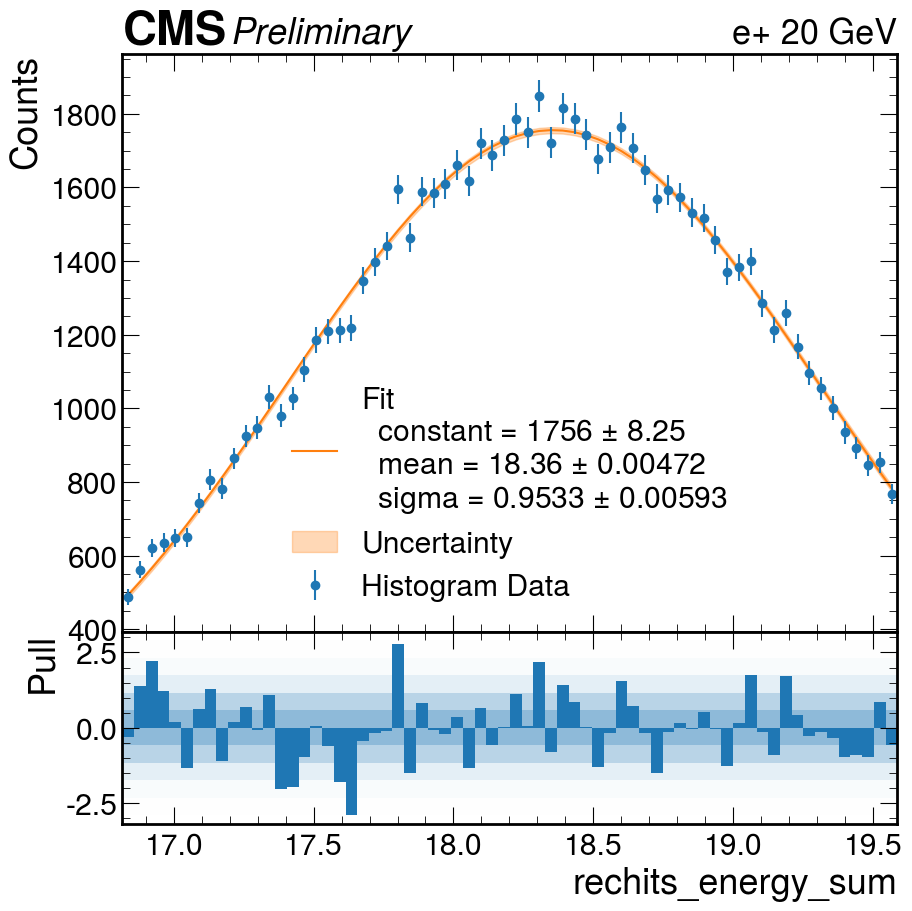

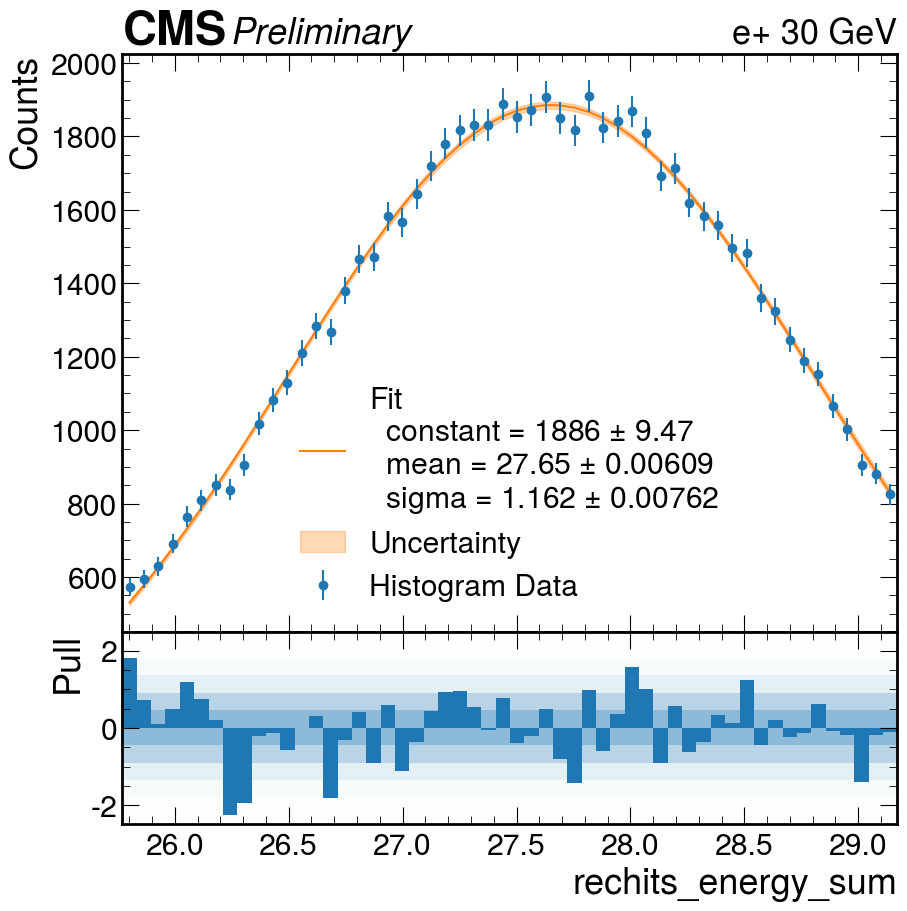

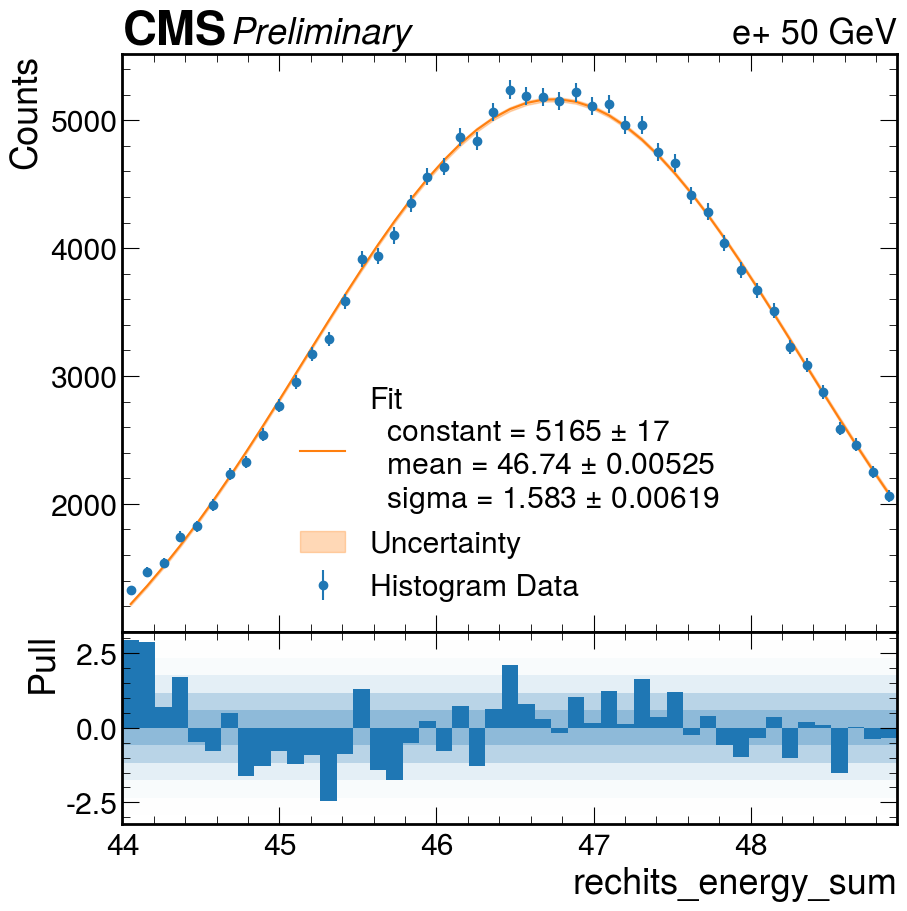

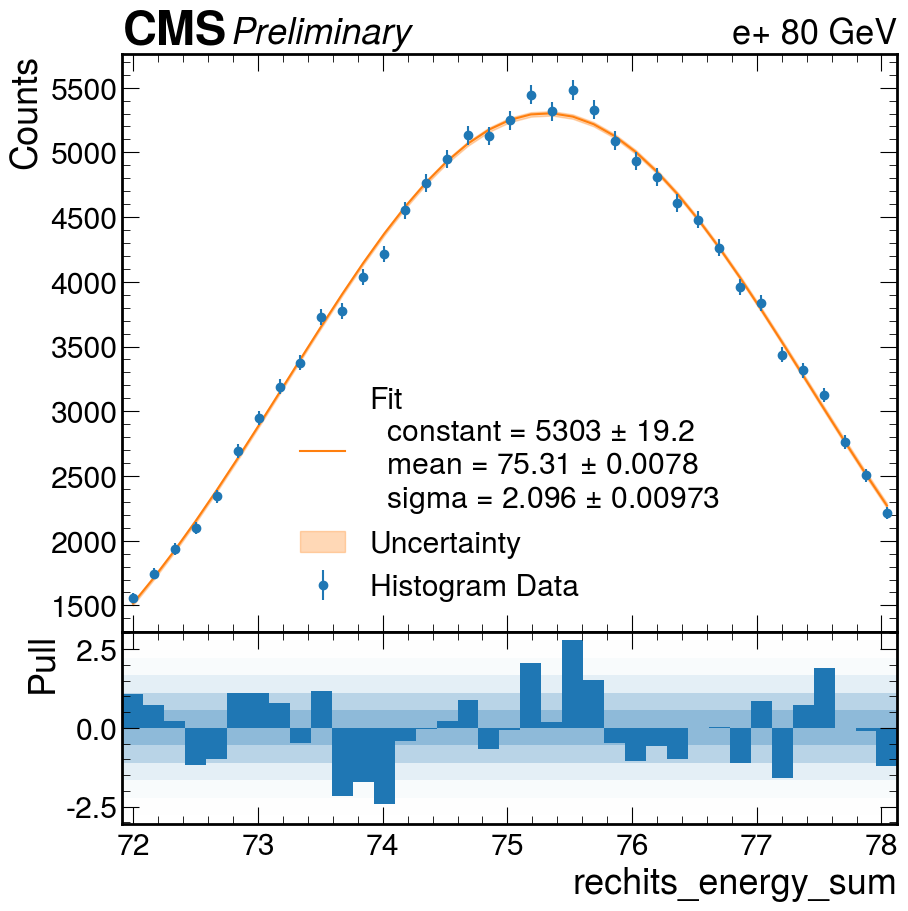

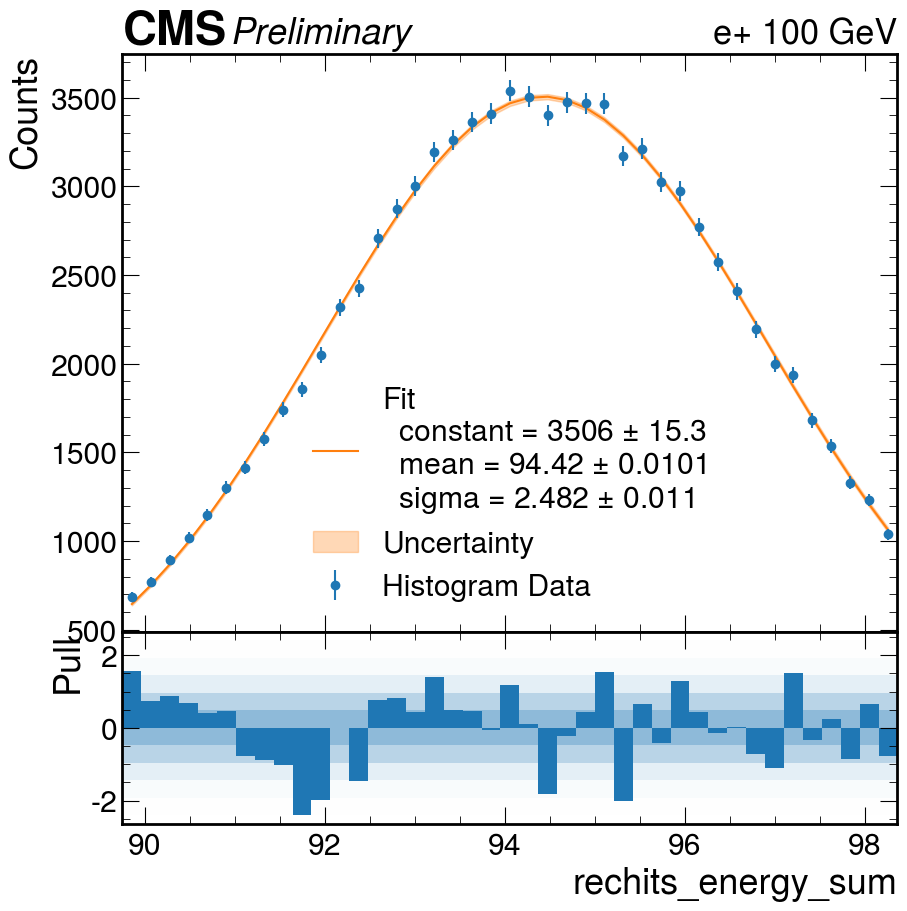

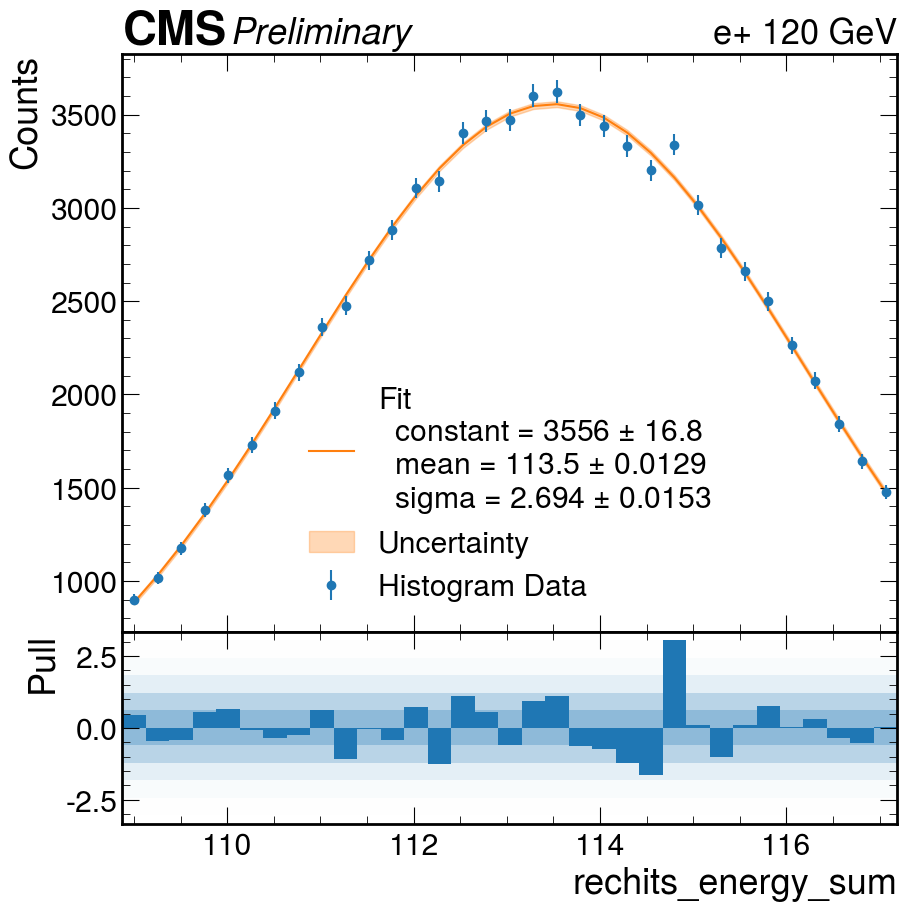

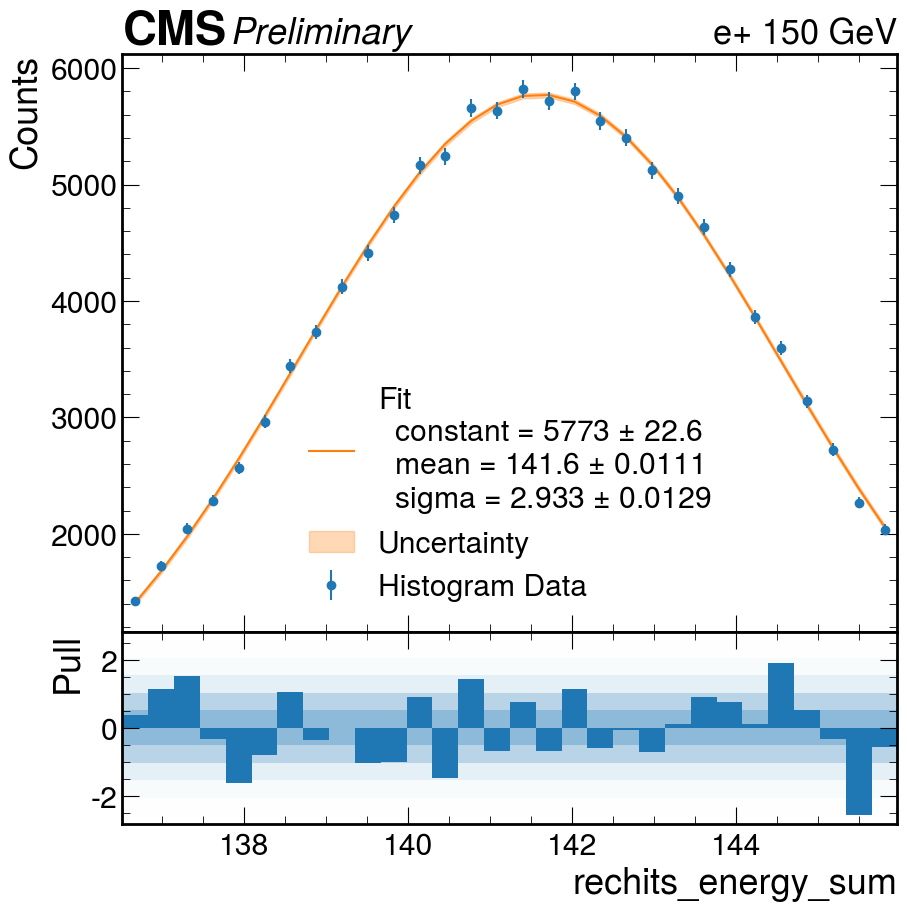

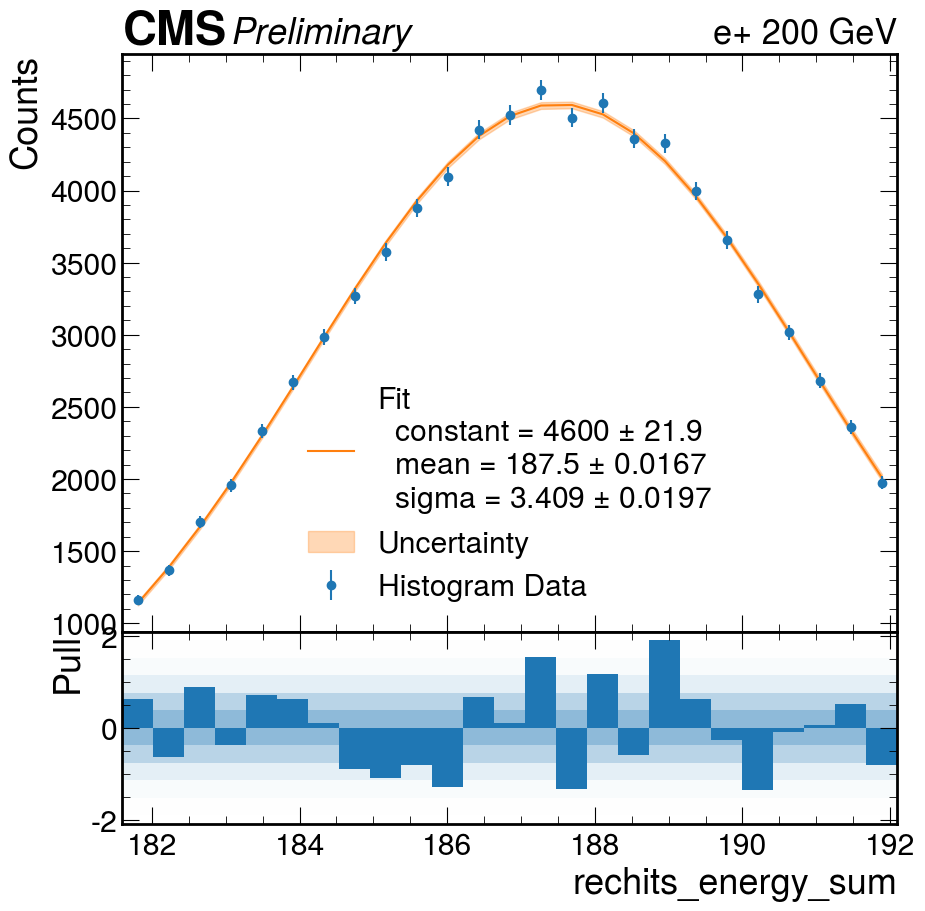

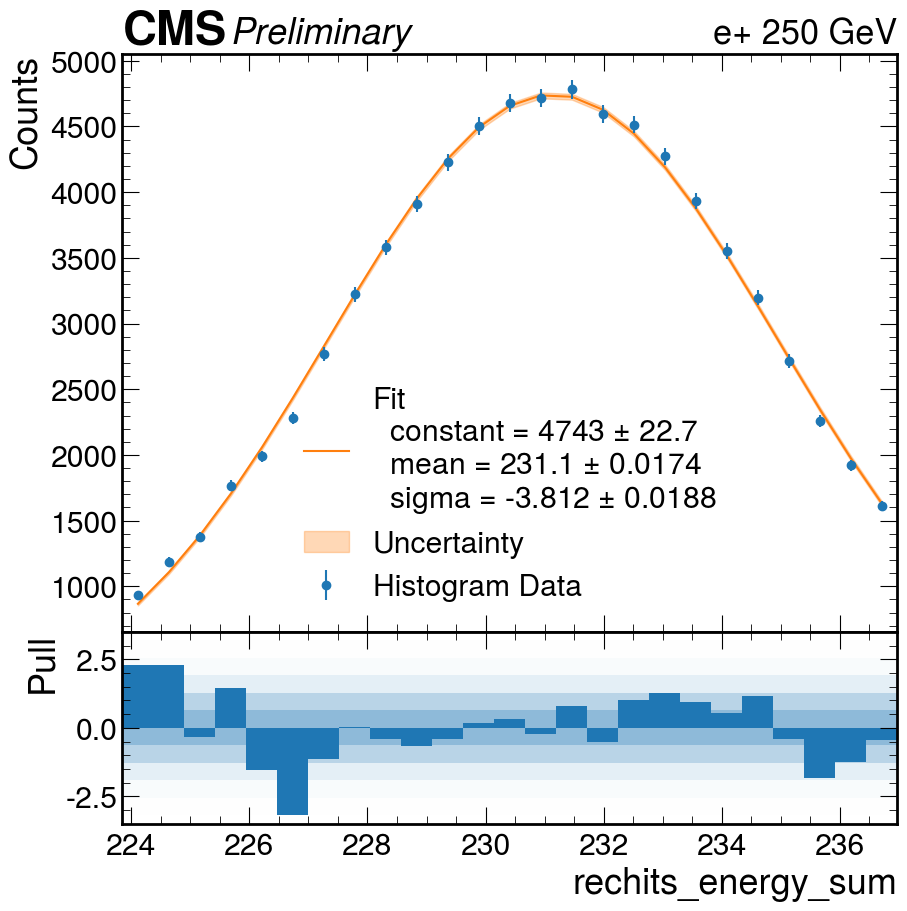

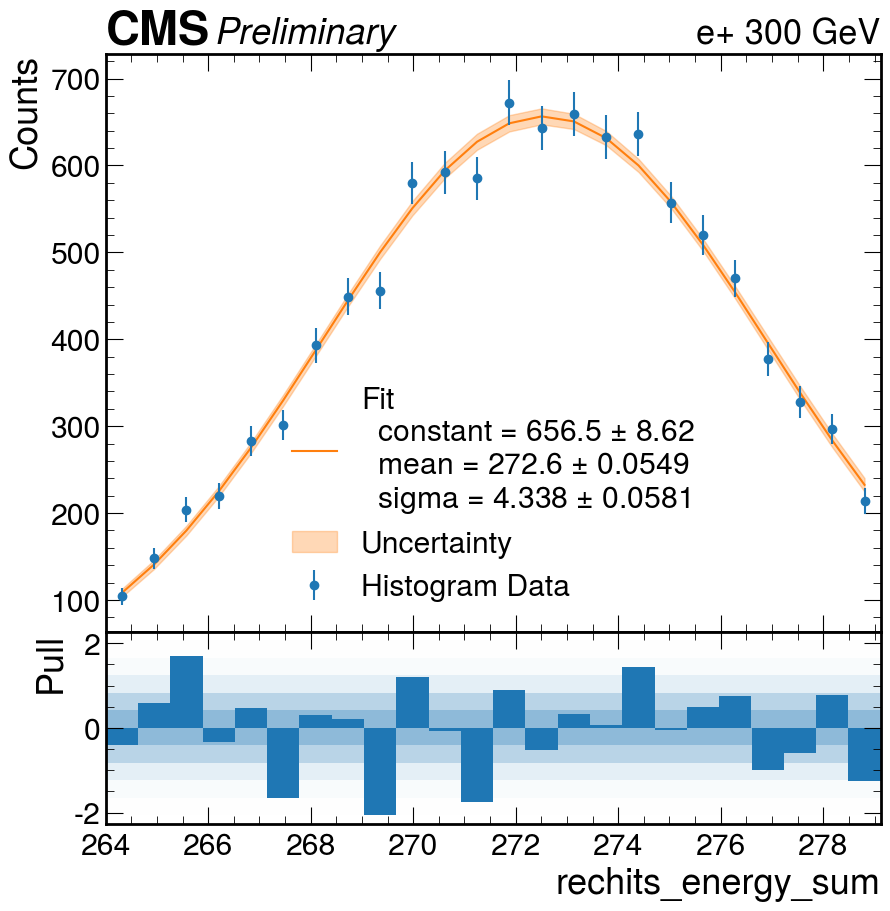

In [23]:
fittedValues["data"] = makeAllFits("data")

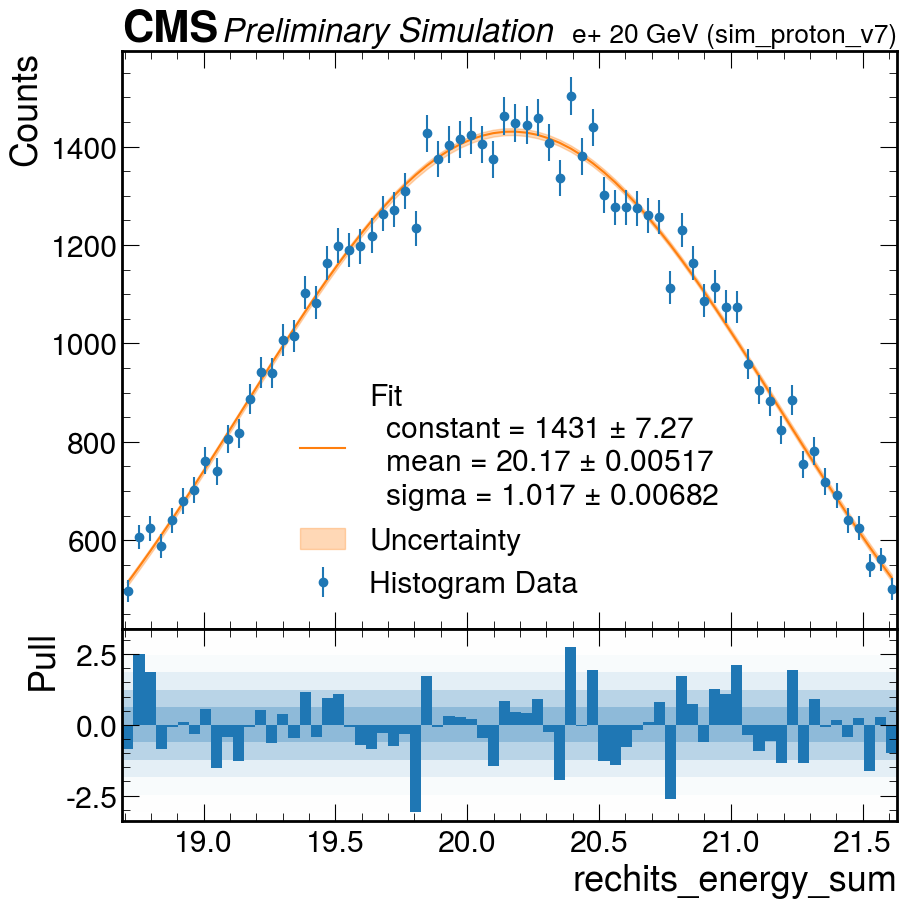

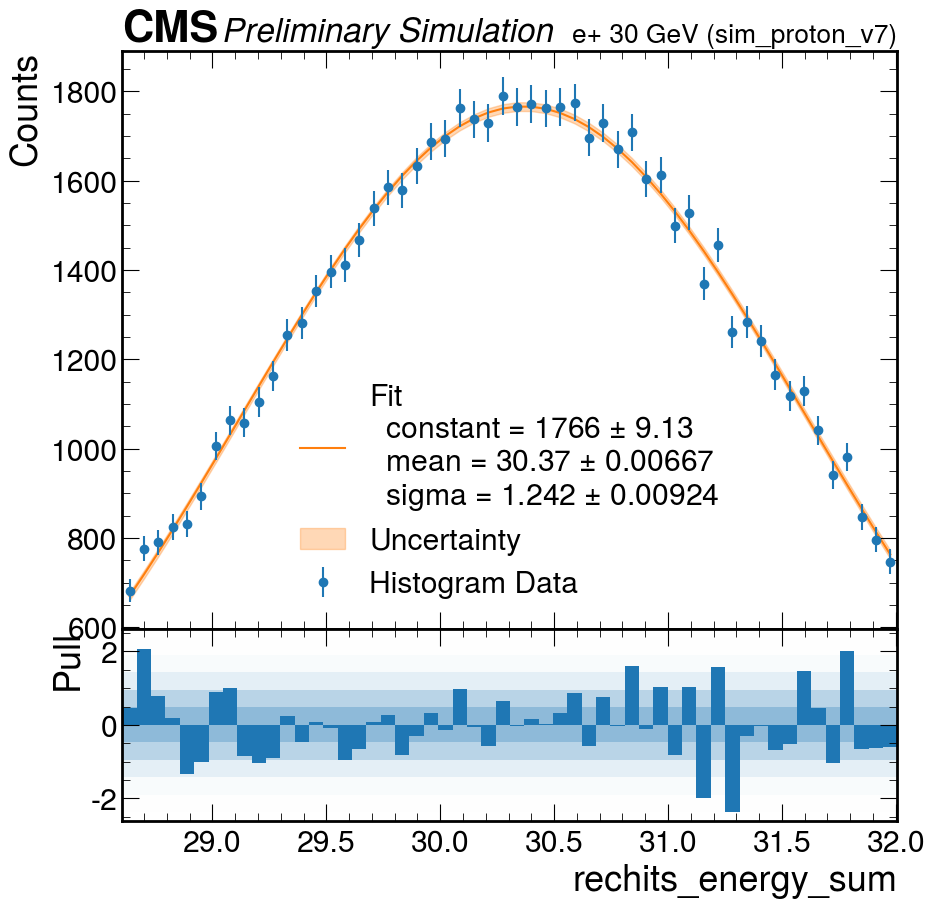

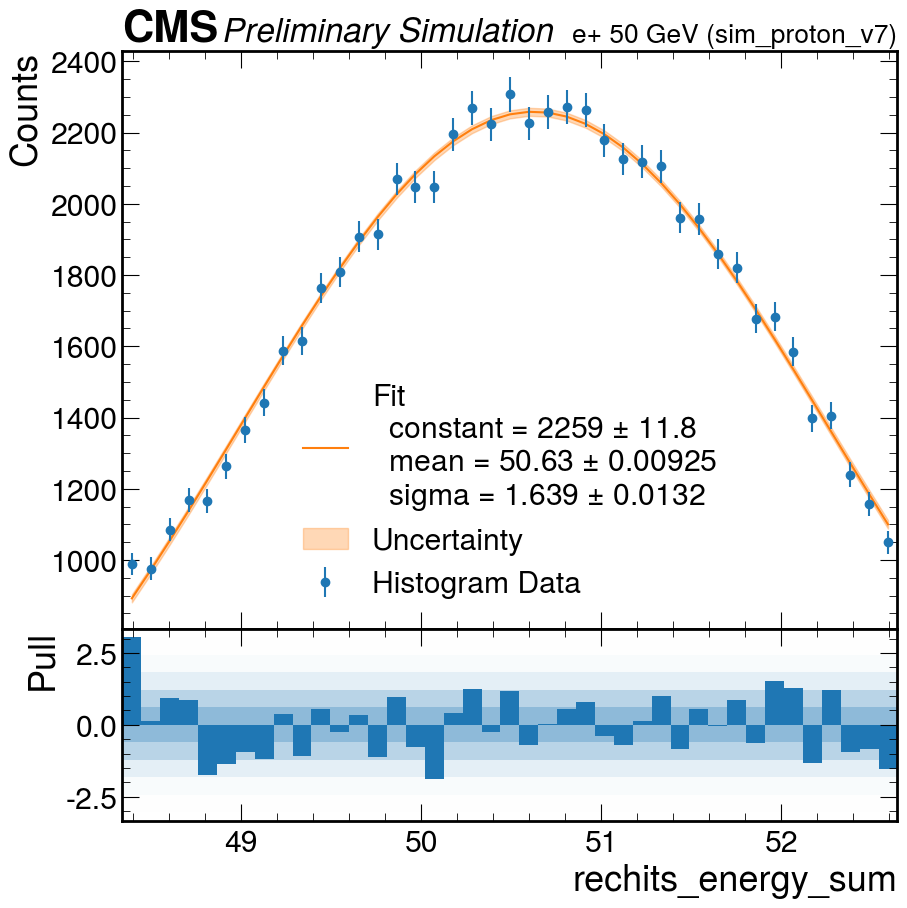

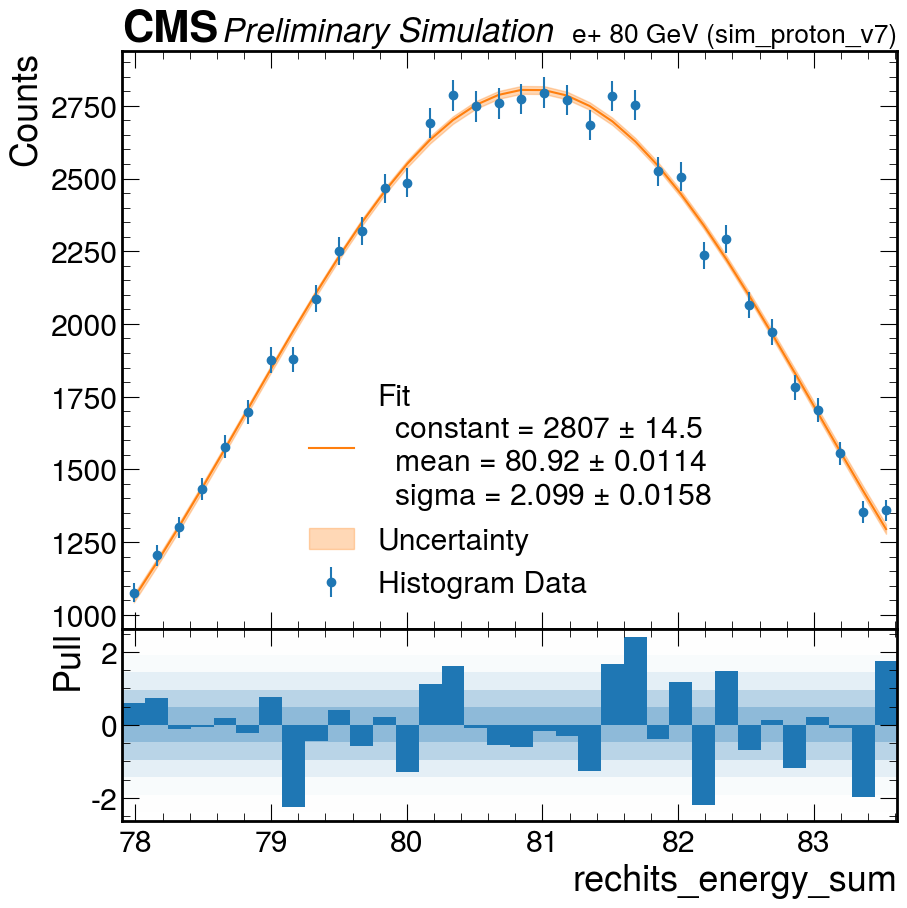

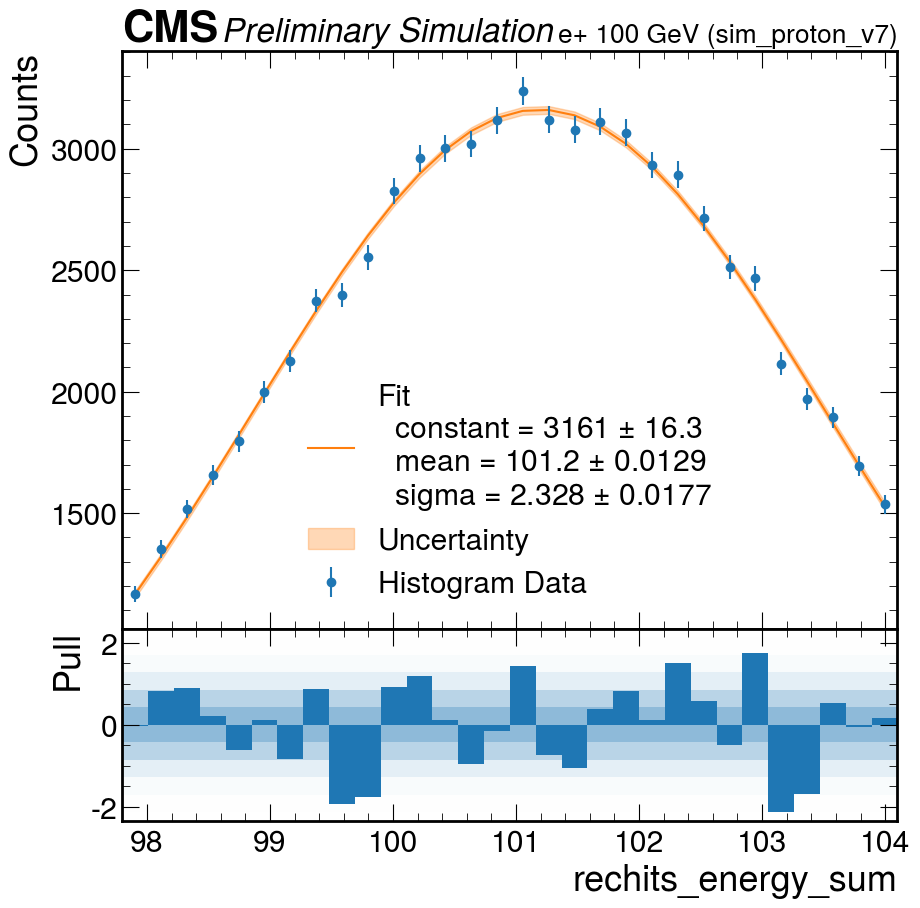

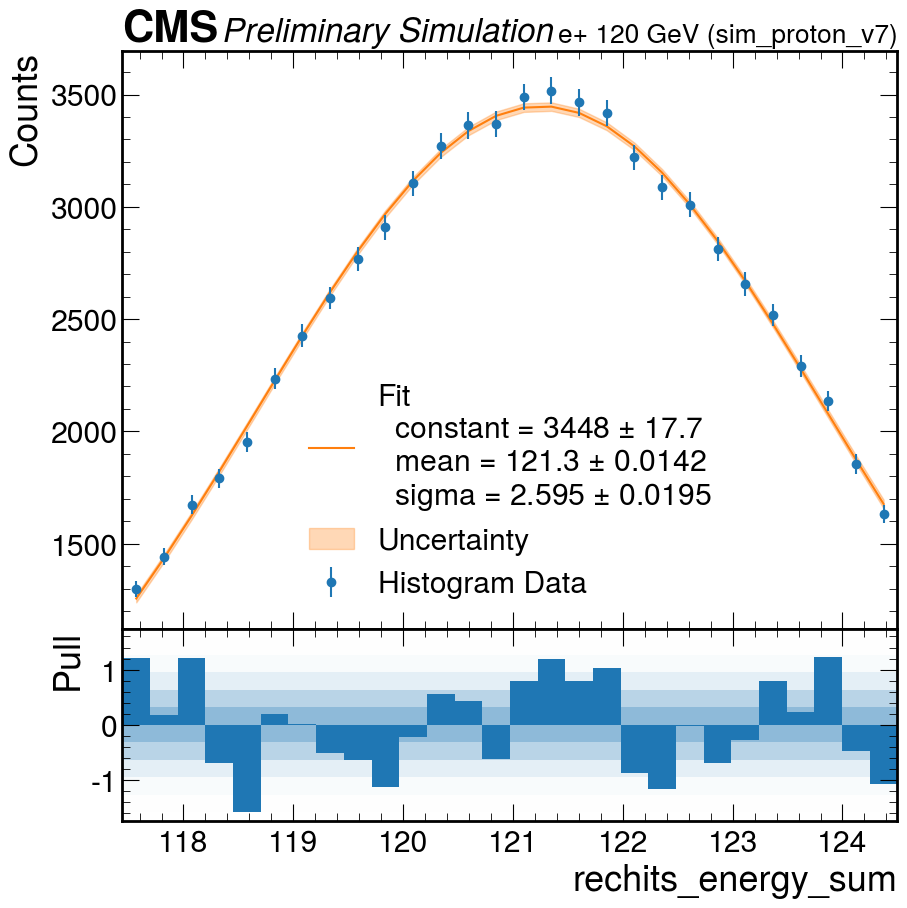

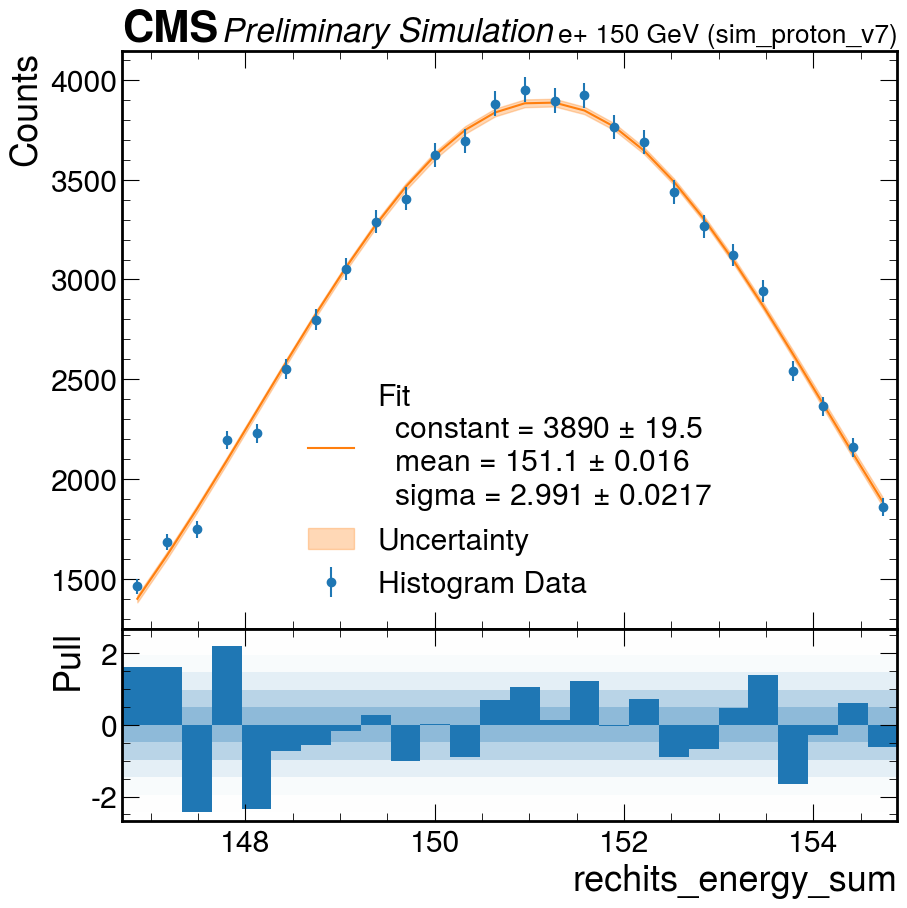

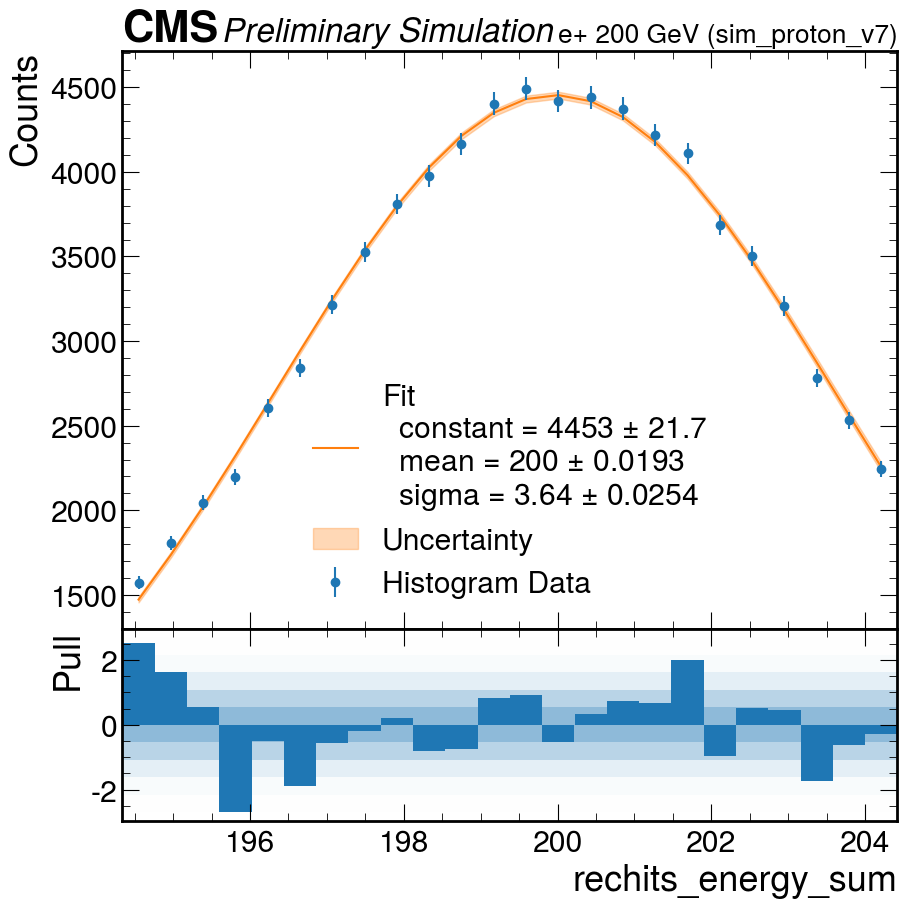

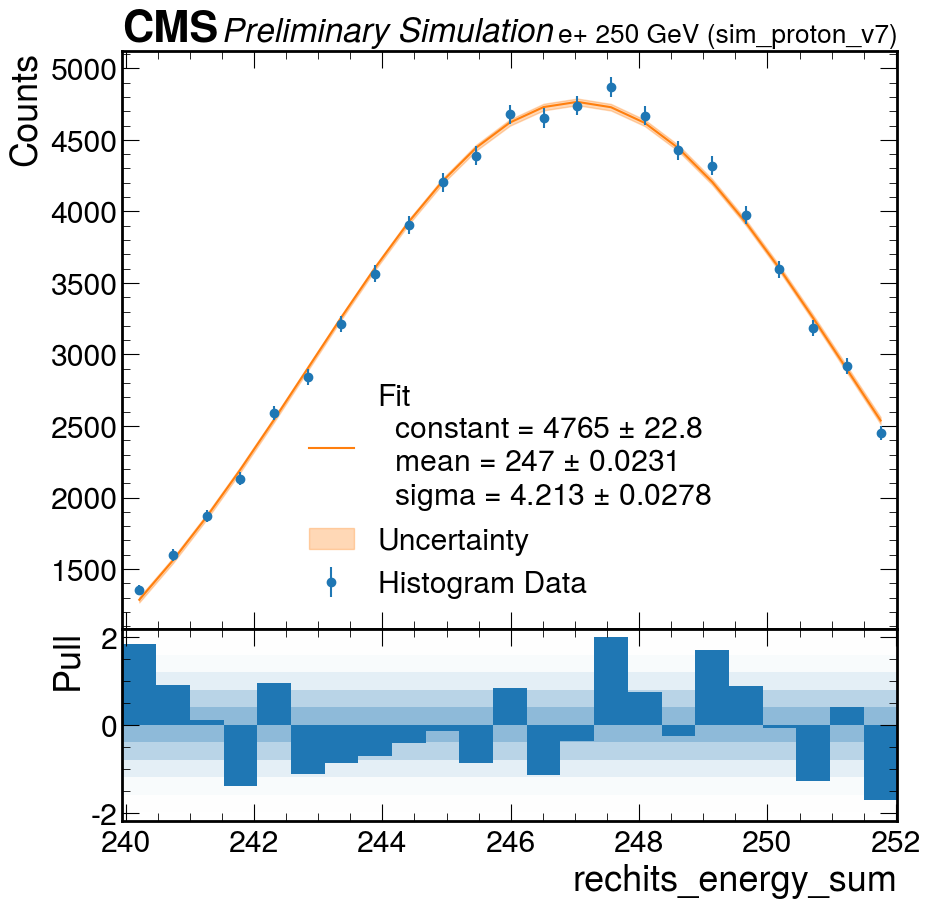

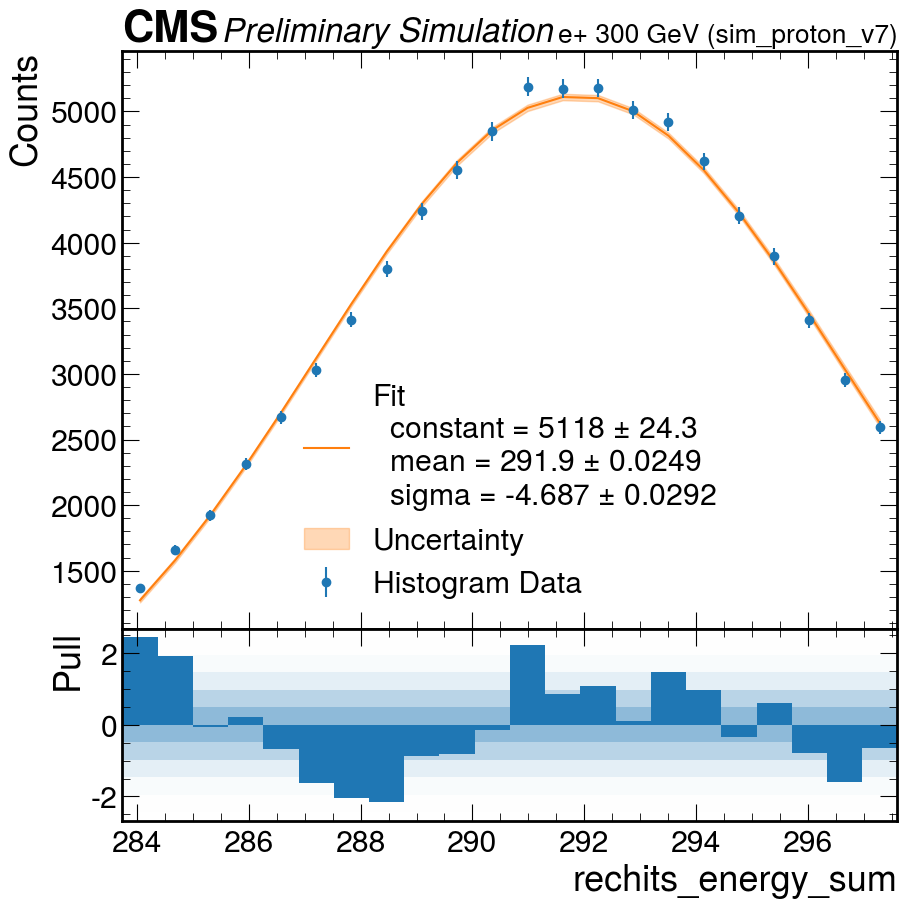

In [24]:
fittedValues["sim_proton_v7"] = makeAllFits("sim_proton_v7")

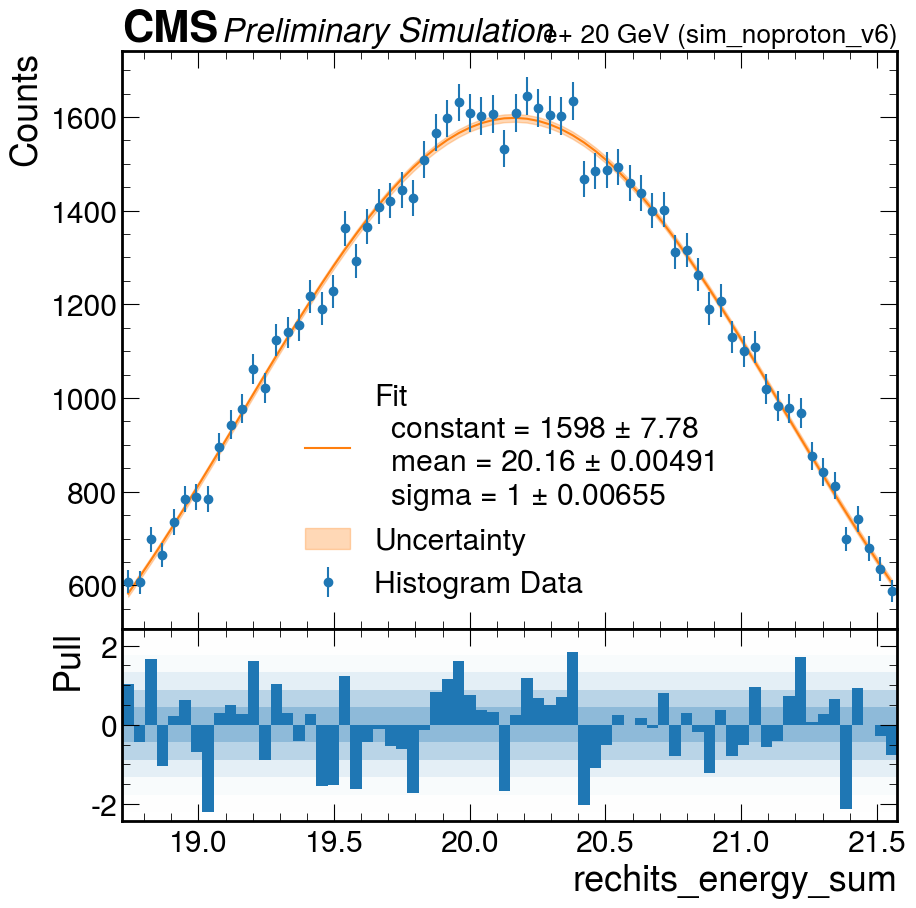

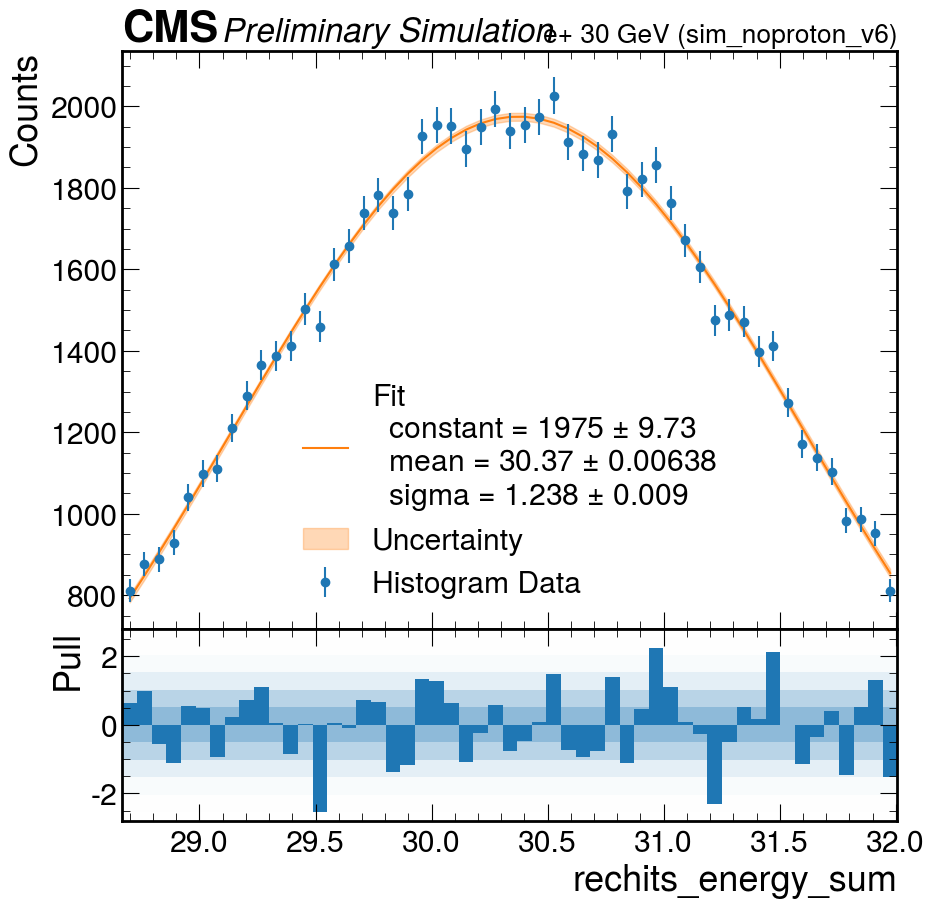

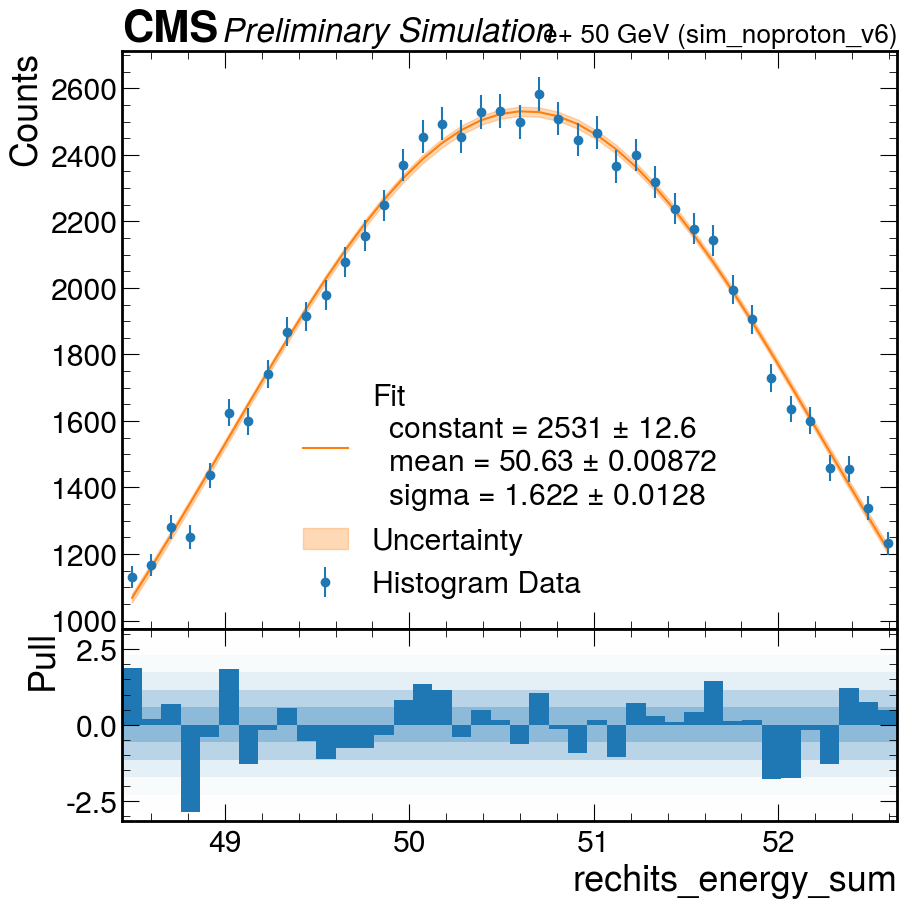

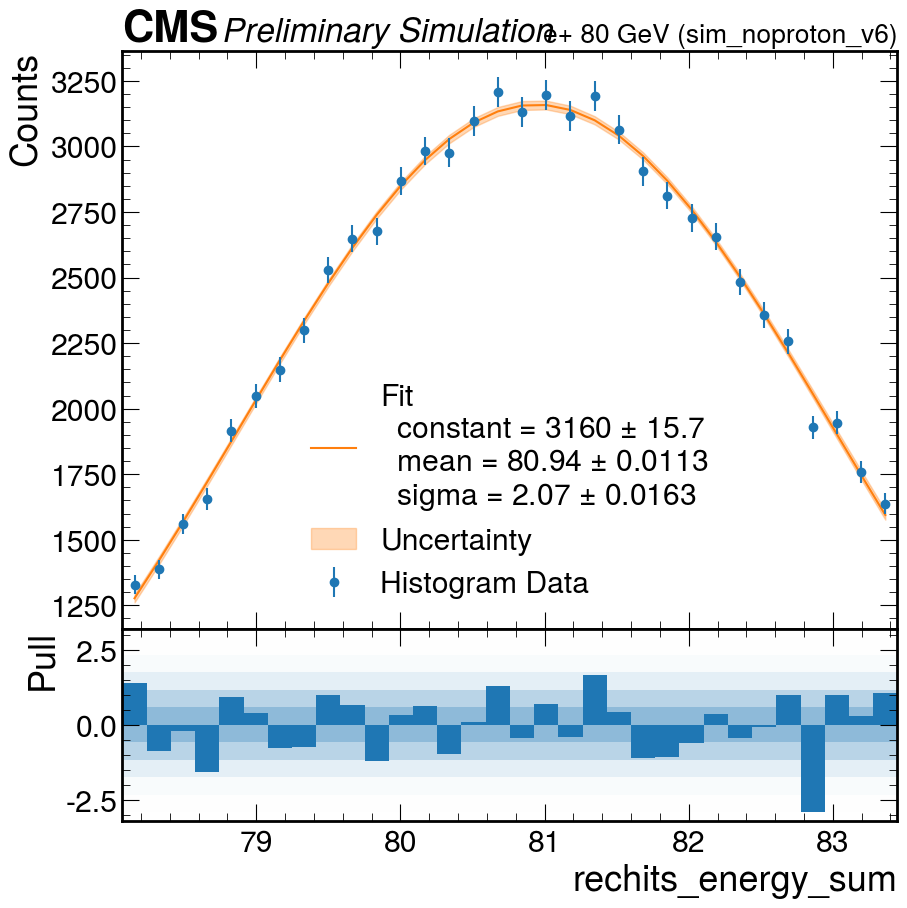

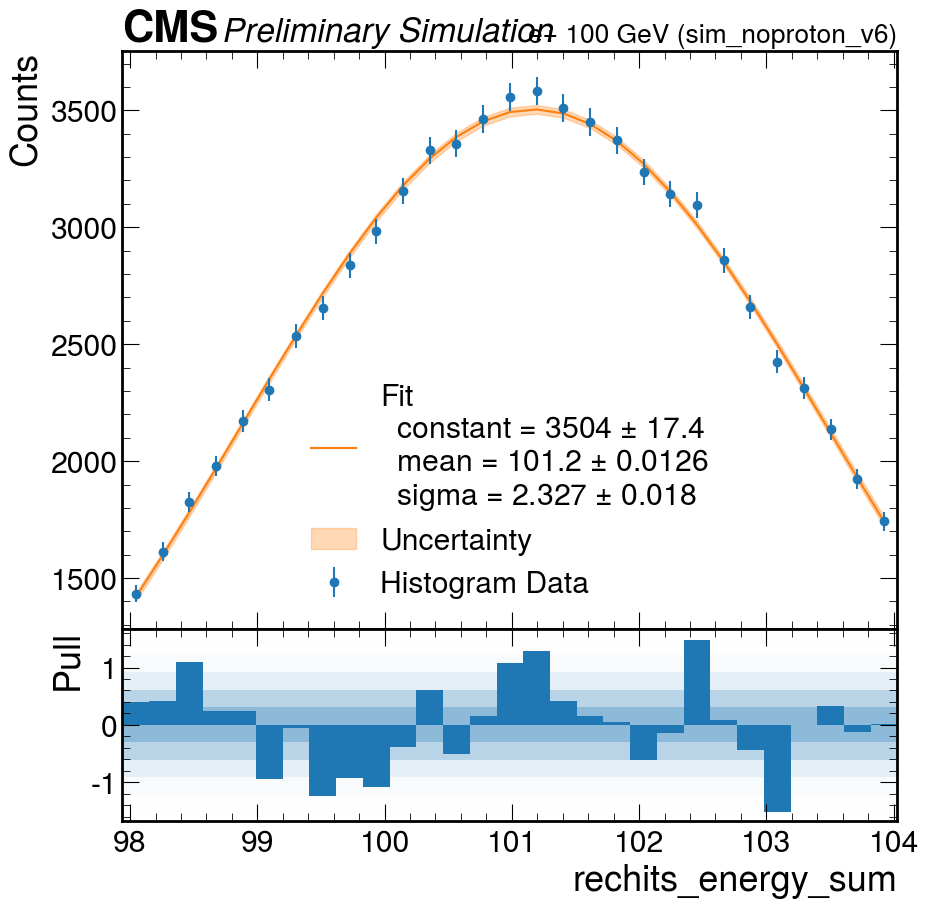

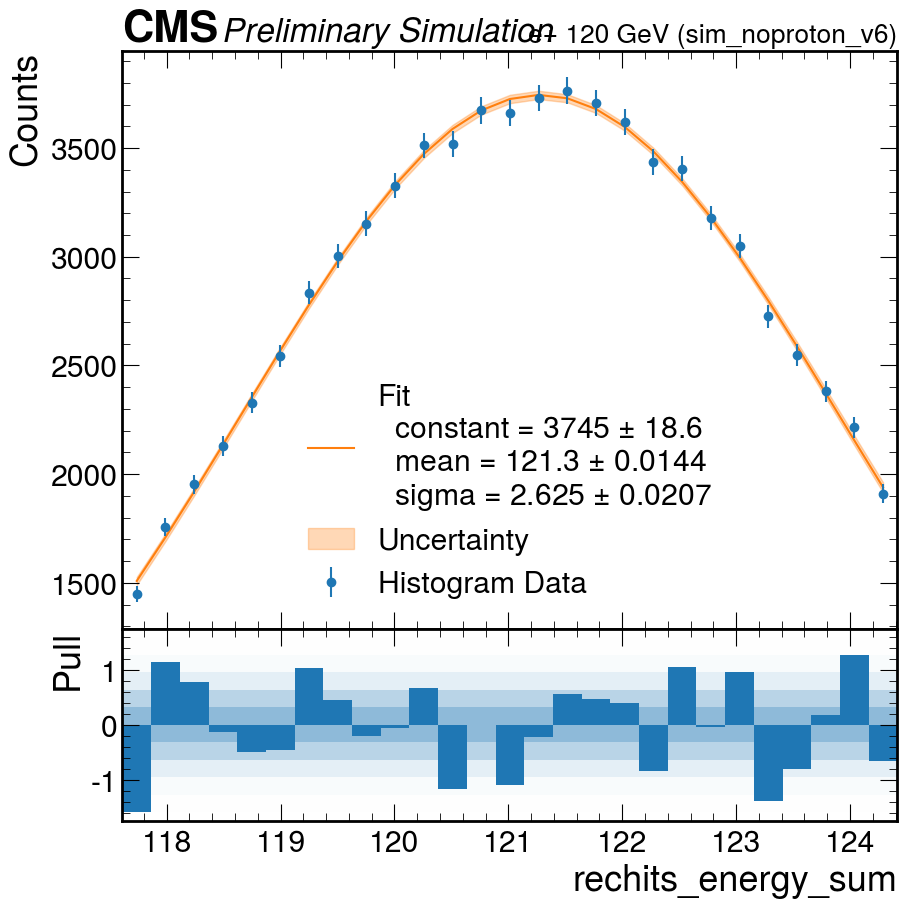

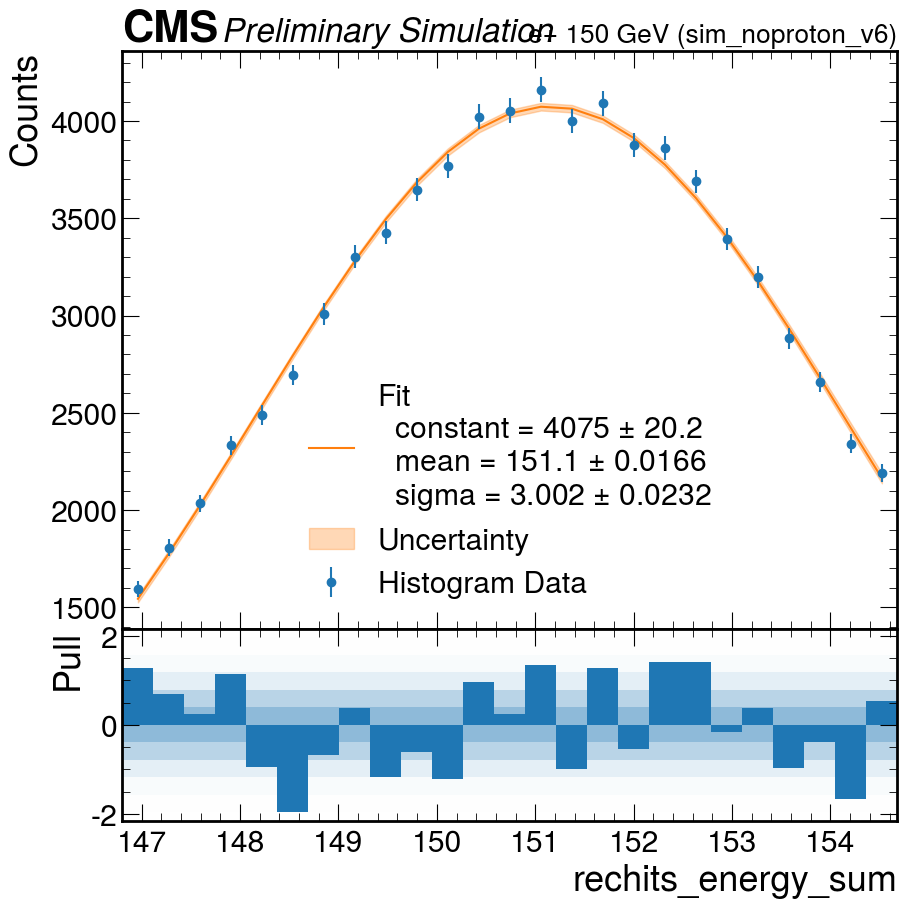

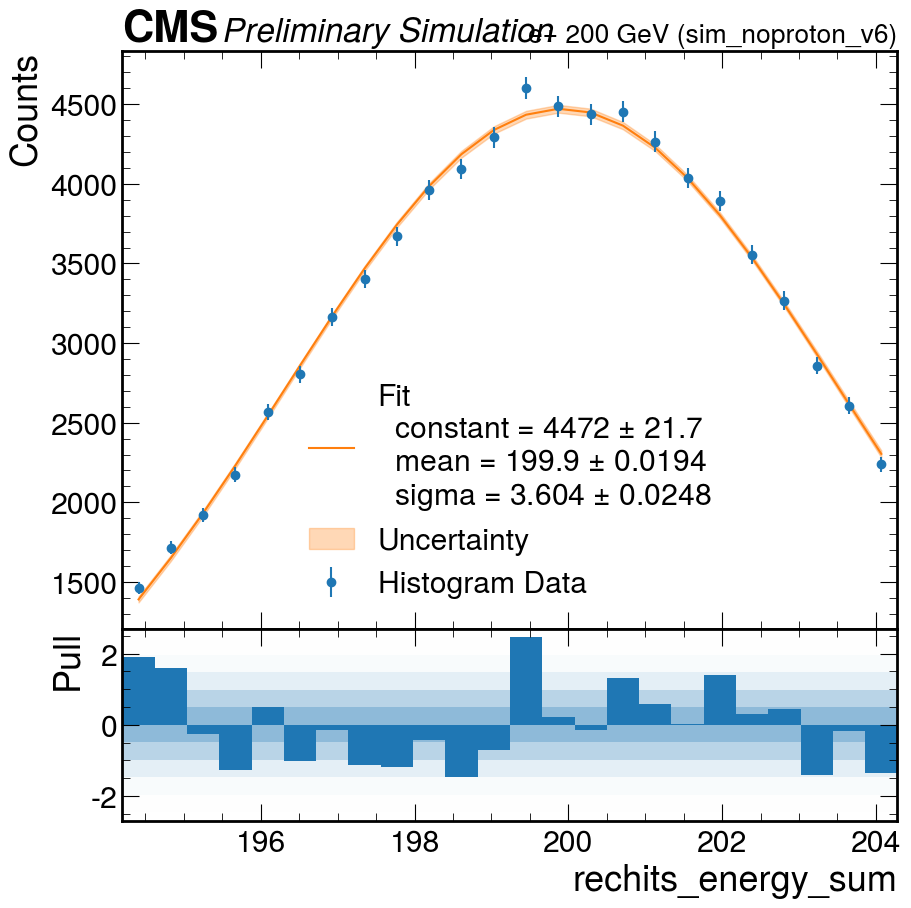

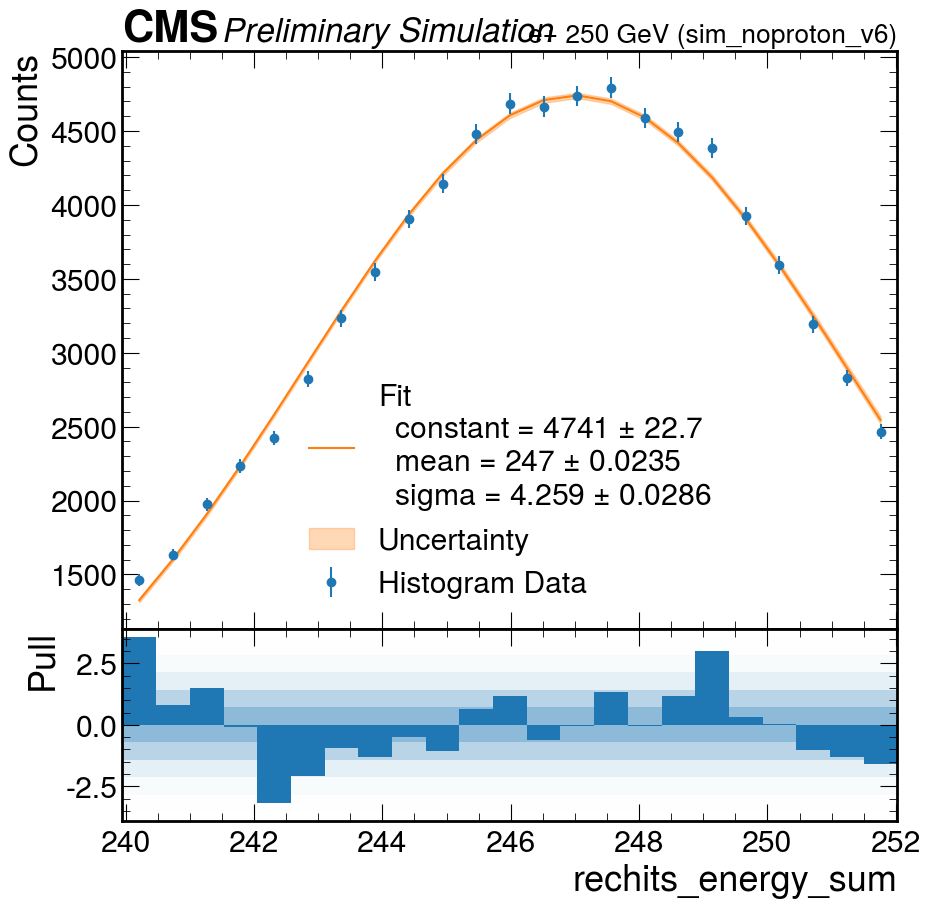

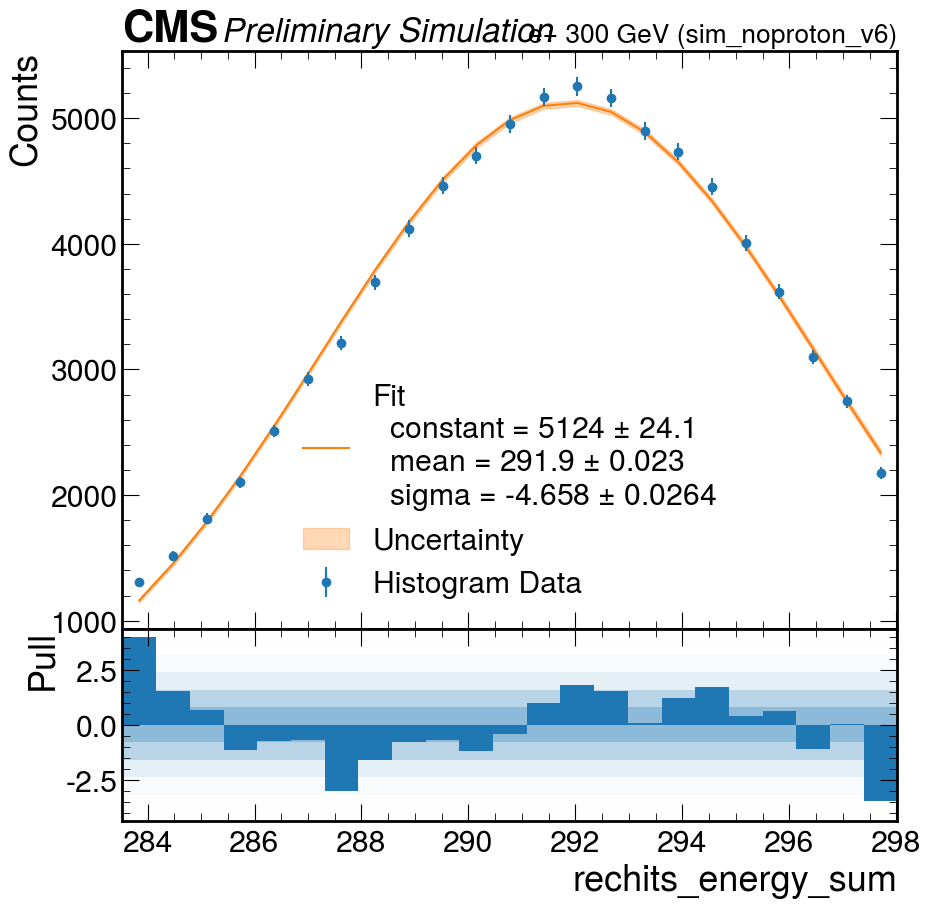

In [25]:
fittedValues["sim_noproton_v6"] = makeAllFits("sim_noproton_v6")

In [26]:
fittedValues

{'data': {20: (18.355823599970847, 0.9533080381566447),
  30: (27.651591747551674, 1.1616235944430047),
  50: (46.74461954042715, 1.5834383597166537),
  80: (75.31433831105778, 2.095950038339667),
  100: (94.42159913194536, 2.481502188934356),
  120: (113.49363219811997, 2.694337812550633),
  150: (141.5975437044436, 2.9331097416484018),
  200: (187.5042045660587, 3.408528473495534),
  250: (231.13992000266416, -3.811854967238164),
  300: (272.55486933806833, 4.3377489808888585)},
 'sim_proton_v7': {20: (20.16760073865514, 1.01740995314272),
  30: (30.366231148226102, 1.2423409049324752),
  50: (50.62638365719052, 1.6391510201780717),
  80: (80.92130738349982, 2.098666090543238),
  100: (101.19019849994301, 2.3279381233211947),
  120: (121.25810367633929, 2.595165751140125),
  150: (151.1343597238268, 2.9912705507169135),
  200: (199.96443313646708, 3.6395271885915657),
  250: (247.03325962628594, 4.213263748850919),
  300: (291.86973168000304, -4.686843265777503)},
 'sim_noproton_v6':

In [27]:
from scipy.stats import linregress
def plotDiff(data, sim, mapBeamEnergy=lambda x:x):
    x = []
    y = []
    for beamEnergy, (data_mean, _) in data.items():
        sim_mean, _ = sim[beamEnergy]
        x.append(beamEnergy)
        y.append(sim_mean-data_mean)
    
    x = np.array(list(map(mapBeamEnergy, x)))
    
    plt.figure()
    plt.plot(x, y, 'o-', label="Simulation - data")
    plt.xlabel("Beam energy (GeV)")
    plt.ylabel("Difference in fitted mean of total reconstrcuted energy (GeV)", fontsize=20)

    fitRes = linregress(x, y)
    plt.plot(x, fitRes.intercept + fitRes.slope*x, 'r', 
        label=f"Linear fit\nSlope = {fitRes.slope:.3g} $\pm$ {fitRes.stderr:.2e}\nIntercept = {fitRes.intercept:.3g} $\pm$ {fitRes.intercept_stderr:.2g}\np-value = {fitRes.pvalue:.3e}")
    
    propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
    plt.plot(x, x*propConstant[0], 'g', 
        label=f"Proportional fit\nSlope = {propConstant[0]:.3g}\nResiduals : {residuals[0]:.3g}")

    hep.cms.text("Preliminary")
    plt.legend()

/tmp/ipykernel_13090/3777122832.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)


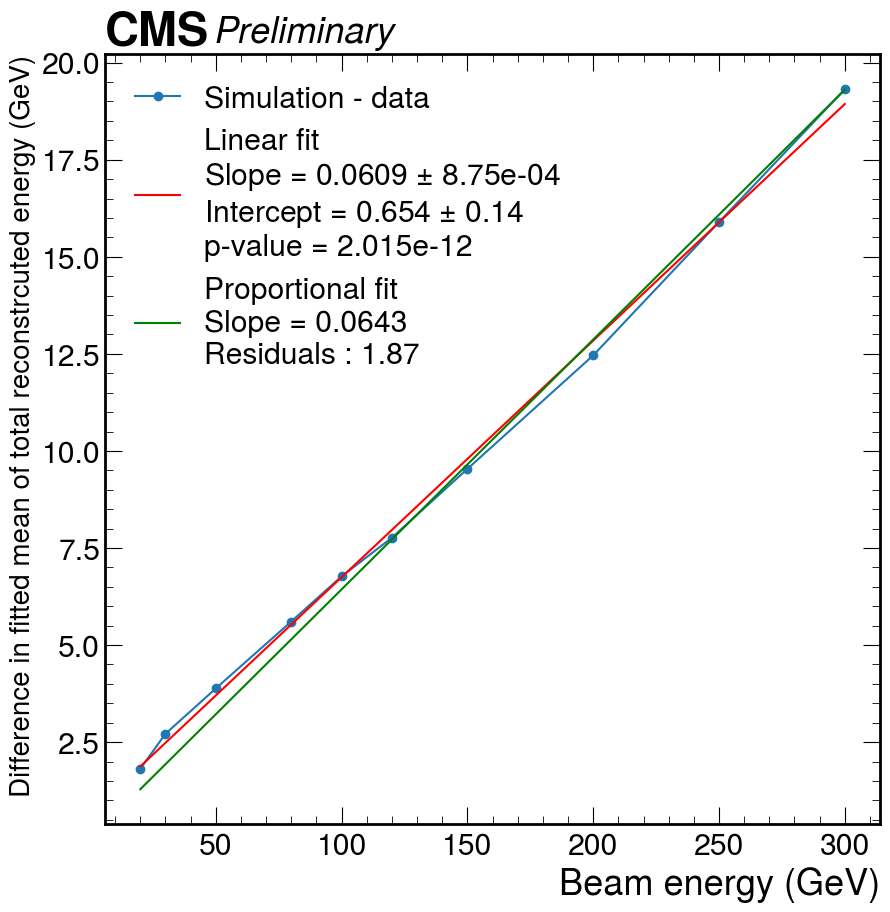

In [28]:
plotDiff(fittedValues["data"], fittedValues["sim_proton_v7"])

/tmp/ipykernel_13090/3777122832.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)


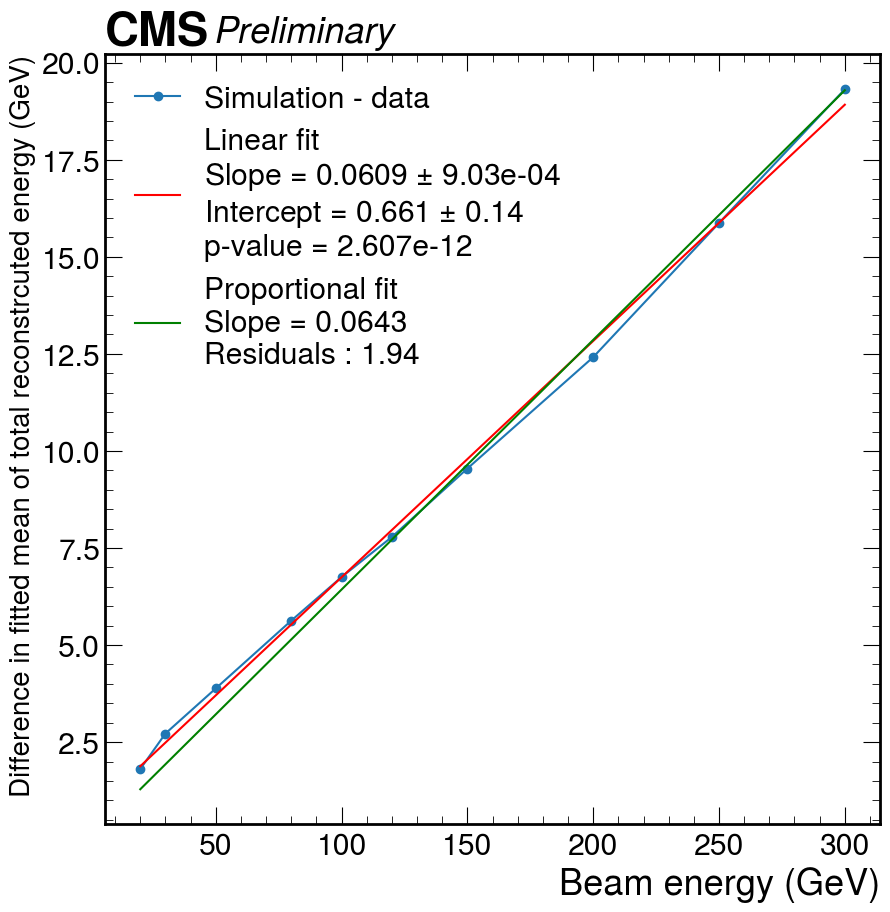

In [29]:
plotDiff(fittedValues["data"], fittedValues["sim_noproton_v6"])

/tmp/ipykernel_13090/3777122832.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)


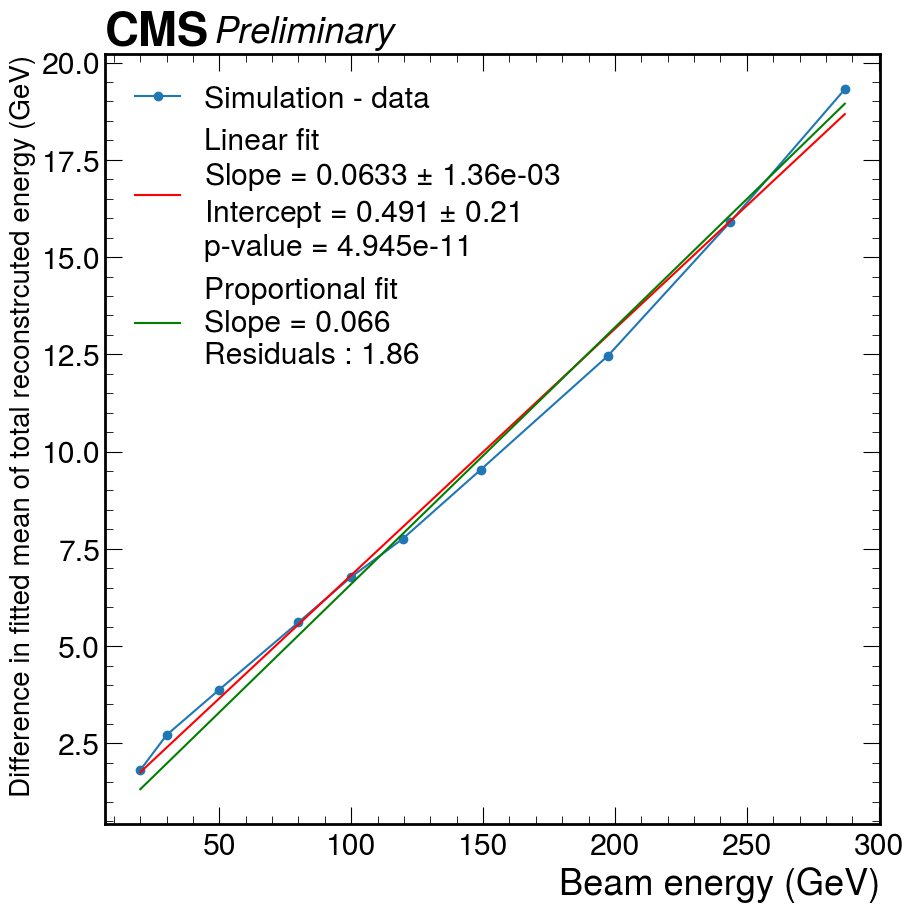

In [30]:
plotDiff(fittedValues["data"], fittedValues["sim_proton_v7"], mapBeamEnergy=lambda x : finalBeamEnergiesMap[x])

In [34]:
# Fit separately data and simulation to match finalBeamEnergiesMap ie the energy of positrons in beam line
def plotDiffToTrueEnergy(fitResults):
    x = []
    y = []
    for beamEnergy, (meanEnergy, _) in fitResults.items():
        x.append(finalBeamEnergiesMap[beamEnergy])
        y.append(meanEnergy-finalBeamEnergiesMap[beamEnergy])
    
    x = np.array(x)
    
    plt.figure()
    plt.plot(x, y, 'o-')
    plt.xlabel("Nominal beam energy (GeV)")
    plt.ylabel("Difference between fitted mean energy and true testbeam energy (GeV)", fontsize=20)

    fitRes = linregress(x, y)
    plt.plot(x, fitRes.intercept + fitRes.slope*x, 'r', 
        label=f"Linear fit\nSlope = {fitRes.slope:.3g} $\pm$ {fitRes.stderr:.2e}\nIntercept = {fitRes.intercept:.3g} $\pm$ {fitRes.intercept_stderr:.2g}\np-value = {fitRes.pvalue:.3e}")
    
    propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)
    plt.plot(x, x*propConstant[0], 'g', 
        label=f"Proportional fit\nSlope = {propConstant[0]:.3g}\nResiduals : {residuals[0]:.3g}")

    hep.cms.text("Preliminary")
    plt.legend()

/tmp/ipykernel_13090/210739235.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)


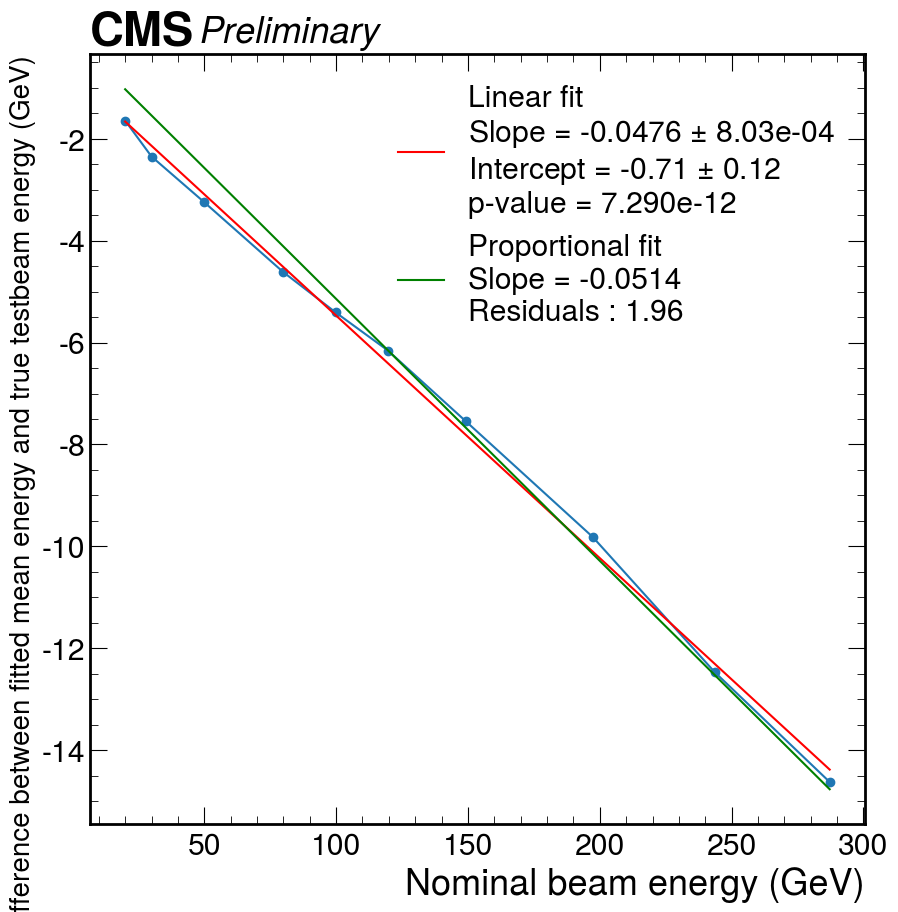

In [35]:
plotDiffToTrueEnergy(fittedValues["data"])

/tmp/ipykernel_13090/721351529.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  propConstant, residuals, _, _ = np.linalg.lstsq(x[:,np.newaxis], y)


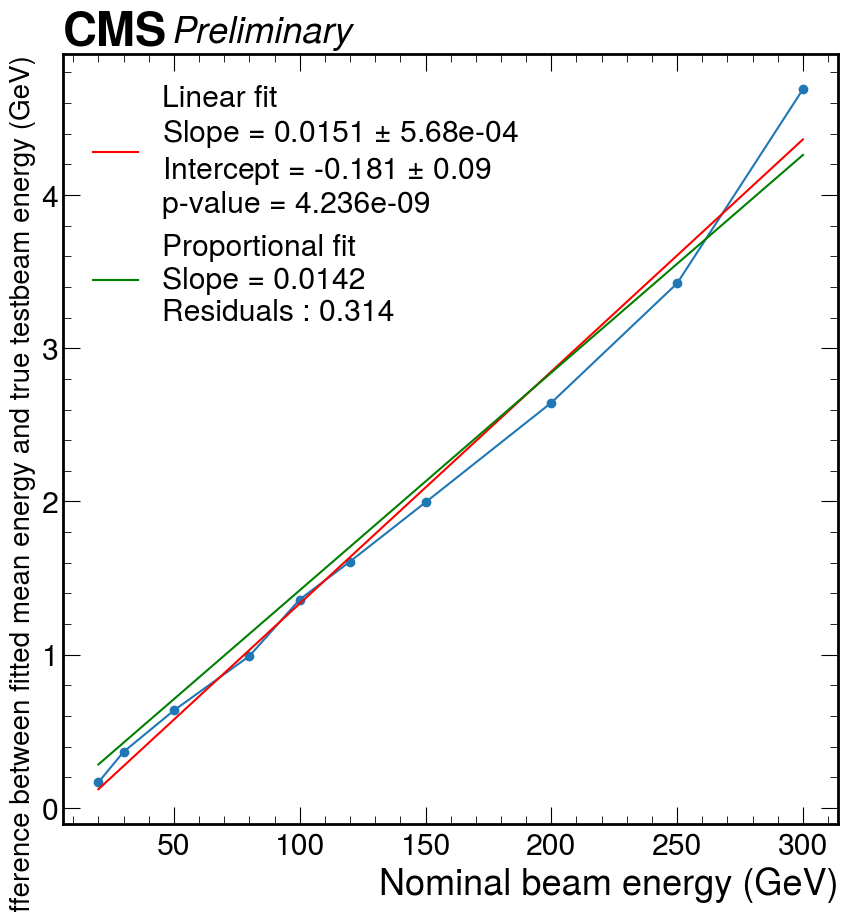

In [33]:
plotDiffToTrueEnergy(fittedValues["sim_proton_v7"])